In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

In [2]:
from proper_cache import clear_all_cached

if False:
    clear_all_cached()

/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
from proper_tools import form_detector_image
from spirals import binarized_ringed_flipped

prescription = 'prescription_rc_quad'

beam_ratio = 0.4
gridsize = 2048
def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)

toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import numpy as np
def view_psf(imarray, pitch_mm, viewport_mm,vmin=None,vmax=None,title=None):
    c = imarray.shape[0]/2. # Assume scaled image
    w = viewport_mm/pitch_mm
    im = plt.imshow(imarray[int(c-w):int(c+w),int(c-w):int(c+w)],cmap='viridis', extent=[x*pitch_mm for x in [-w,w,-w,w]], norm=LogNorm(),vmin=vmin, vmax=vmax)
    if title is not None:
        plt.title(title)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


In [5]:
viewport = 1. # mm

Use a simple monochromatic (600nm) PSF.

In [6]:
wl_vals = [0.6]
# [5.999989e-01, 6.026560e-01, 6.068356e-01, 6.119202e-01, 6.173624e-01, 6.226281e-01, 6.270944e-01, 6.300010e-01 ]
wl_weights = [1.]
#[5.3770e-02, 1.1224e-01, 1.5056e-01, 1.7034e-01, 1.7342e-01, 1.5861e-01, 1.2166e-01, 5.9360e-02 ]

In [7]:
# First source, on axis
source_a = {
            'wavelengths': wl_vals,
            'weights': wl_weights,
            'settings': toliman_settings
            }

## Proper PSF using single source and `form_detector_image` 

In [8]:
detector_centred_ref = form_detector_image(prescription, [source_a], gridsize, detector_pitch, npixels)

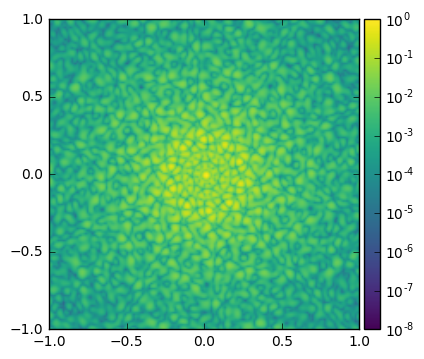

In [9]:
%matplotlib inline
view_psf(detector_centred_ref/detector_centred_ref.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.show()

## Should get same results using two separate steps

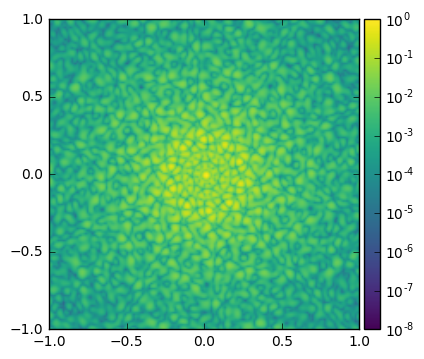

In [12]:
from proper_tools import fix_prop_pixellate, form_multi_psf
common_sampling = detector_pitch/2. # for Nyquist 
psf_all = form_multi_psf('prescription_rc_quad', [source_a], gridsize, common_sampling, npixels*2)
final_im_centred = fix_prop_pixellate(psf_all, common_sampling, detector_pitch, offset=(0,0))
view_psf(final_im_centred/final_im_centred.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)

In [13]:
print(((final_im_centred/final_im_centred.max(axis=None) - detector_centred_ref/detector_centred_ref.max(axis=None))**2).sum())

0.0


# Hand-code the FFT translation

In [14]:
dx=10
dy=20
m_per_as = 15. * np.pi / (3600 * 180)
print("Grid scale is {} m/sample".format(common_sampling))
print("Angular scale is {} m/as".format(m_per_as))
print("Grid angular scale is {} as/sample".format(common_sampling/m_per_as))
offset_as = (dx*(common_sampling/m_per_as),dy*(common_sampling/m_per_as))
print("Displacement is ({},{}) as".format(offset_as[0],offset_as[1]))
print("Displacement is ({},{}) samples".format(offset_as[0]/(common_sampling/m_per_as),offset_as[1]/(common_sampling/m_per_as)))


Grid scale is 5.5e-06 m/sample
Angular scale is 7.27220521664304e-05 m/as
Grid angular scale is 0.07563042895726867 as/sample
Displacement is (0.7563042895726867,1.5126085791453734) as
Displacement is (10.0,20.0) samples


Shifted peak amplitude changed to 100.0%


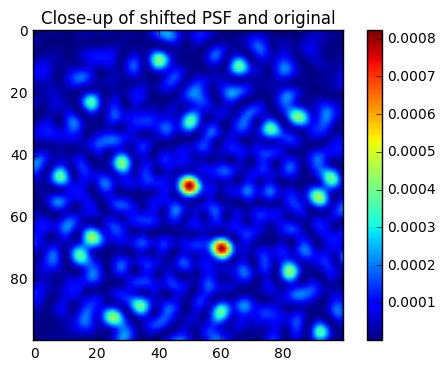

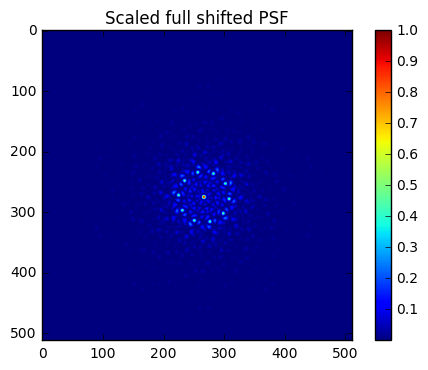

In [22]:
psf_shifted_ft = np.fft.fft2(np.fft.fftshift(psf_all))
n_in = psf_all.shape[0]
w = int(n_in/2.)
vals = np.arange(-w, w)
xoff,yoff = np.meshgrid(vals,vals)
psf_shifted_ft*=np.exp(-1j*2*np.pi*(xoff*offset_as[0]*m_per_as+yoff*offset_as[1]*m_per_as)/(common_sampling*n_in))

psf_shifted_ft_ift = np.fft.ifftshift(np.abs(np.fft.ifft2(psf_shifted_ft)))
print("Shifted peak amplitude changed to {}%".format(100.*psf_shifted_ft_ift.max(axis=None)/psf_all.max(axis=None)))
plt.imshow((psf_shifted_ft_ift+psf_all)[512-50:512+50,512-50:512+50])
plt.colorbar()
plt.title('Close-up of shifted PSF and original')
plt.show()  
plt.imshow((psf_shifted_ft_ift/psf_shifted_ft_ift.max(axis=None))[256:1024-256,256:1024-256])
plt.colorbar()
plt.title('Scaled full shifted PSF')
plt.show()  


## Compare to directly rendered image

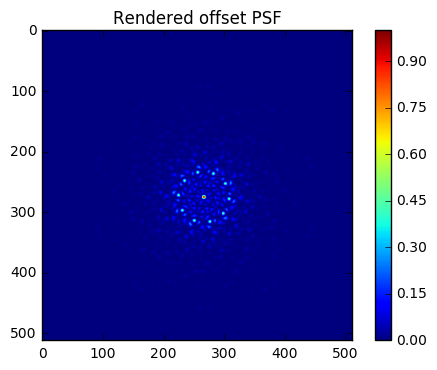

In [23]:
offset_config = toliman_settings.copy()
offset_config['tilt_x']=offset_as[0] # arcsecs
offset_config['tilt_y']=offset_as[1] # arcsecs
offset_source = source_a.copy()
offset_source['settings'] = offset_config
offset_psf_all = form_multi_psf('prescription_rc_quad', [offset_source], gridsize, common_sampling, npixels*2)

plt.imshow((offset_psf_all/offset_psf_all.max(axis=None))[256:1024-256,256:1024-256])
plt.colorbar()
plt.title('Rendered offset PSF')
plt.show()

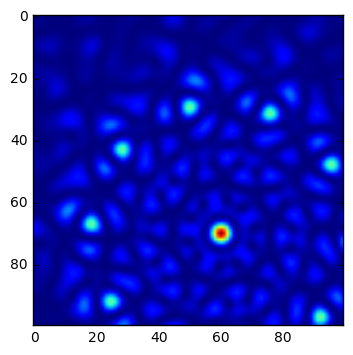

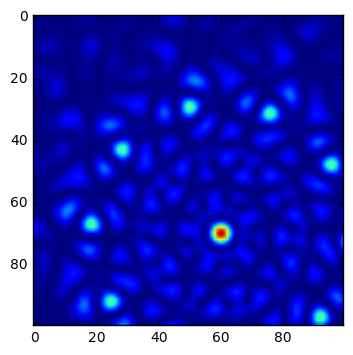

In [26]:
plt.imshow((offset_psf_all/offset_psf_all.max(axis=None))[512-50:512+50,512-50:512+50])
plt.show()
plt.imshow((psf_shifted_ft_ift/psf_shifted_ft_ift.max(axis=None))[512-50:512+50,512-50:512+50])
plt.show()

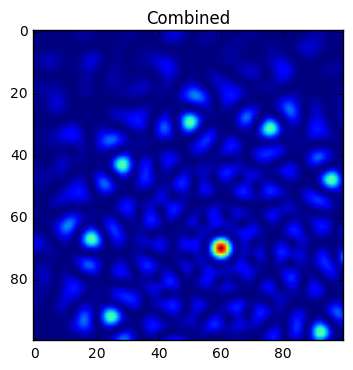

In [29]:
plt.imshow(((offset_psf_all/offset_psf_all.max(axis=None)) + (psf_shifted_ft_ift/psf_shifted_ft_ift.max(axis=None)))[512-50:512+50,512-50:512+50])
plt.title('Combined')
plt.show()

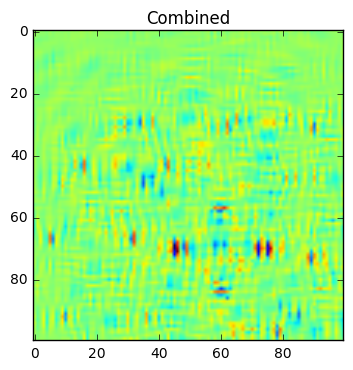

In [30]:
plt.imshow(((offset_psf_all/offset_psf_all.max(axis=None)) - (psf_shifted_ft_ift/psf_shifted_ft_ift.max(axis=None)))[512-50:512+50,512-50:512+50])
plt.title('Combined')
plt.show()

7.52744000989e-10


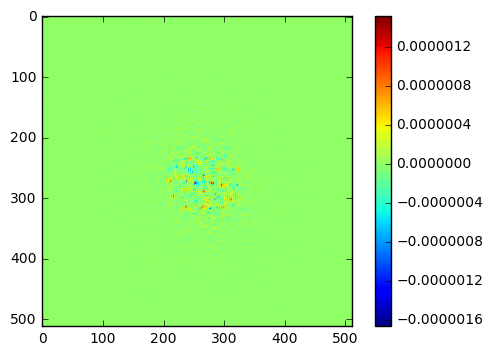

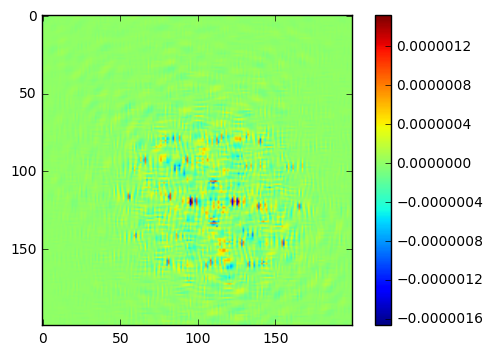

In [27]:
errmap = offset_psf_all - psf_shifted_ft_ift
print((errmap**2).sum())
plt.imshow((errmap)[256:1024-256,256:1024-256])
plt.colorbar()
plt.show()  
plt.imshow((errmap)[512-100:512+100,512-100:512+100])
plt.colorbar()
plt.show()  

In [20]:
#common_sampling = detector_pitch/2. # for Nyquist
offsets = [0,0.001,0.01, 0.1, 1.0, 10.0]
errors = []
offset_source = source_a.copy()
offset_config = toliman_settings.copy()
offset_source['settings'] = offset_config

# Render a tilted wavefront and then offset it back and compare to the centred one
for dx in offsets:
    for dy in offsets:
        offset_config['tilt_x']=-dx # arcsecs
        offset_config['tilt_y']=-dy # arcsecs
        offset_source['settings'] = offset_config
        psf_tilted = form_multi_psf('prescription_rc_quad', [offset_source], gridsize, common_sampling, npixels*2)
        im_recentred = fix_prop_pixellate(psf_tilted, common_sampling, detector_pitch, offset=(dx*m_per_as,dy*m_per_as))
        error = ((im_recentred - detector_centred_ref)**2).sum()
        print(dx,dy,error)
        errors.append((dx,dy,error))


0 0 0.0
0 0.001 1.07605467153e-13
0 0.01 1.06354534077e-11
0 0.1 2.67137686486e-10
0 1.0 2.71363884387e-10
0 10.0 2.10626673424e-08
0.001 0 9.14788050823e-14
0.001 0.001 1.99337006347e-13
0.001 0.01 1.07296243052e-11
0.001 0.1 2.67232802382e-10
0.001 1.0 2.71469805481e-10
0.001 10.0 2.10630781999e-08
0.01 0 9.04226660815e-12
0.01 0.001 9.15266610851e-12
0.01 0.01 1.97074183918e-11
0.01 0.1 2.76248146042e-10
0.01 1.0 2.80835339497e-10
0.01 10.0 2.10779055327e-08
0.1 0 2.29283261041e-10
0.1 0.001 2.29394783831e-10
0.1 0.01 2.39999570881e-10
0.1 0.1 4.98282745102e-10
0.1 1.0 5.0805120733e-10
0.1 10.0 2.1372587544e-08
1.0 0 2.63168780847e-10
1.0 0.001 2.63306648936e-10
1.0 0.01 2.74463678105e-10
1.0 0.1 5.39447019447e-10
1.0 1.0 5.35681049795e-10
1.0 10.0 2.13643332069e-08
10.0 0 2.09872372241e-08
10.0 0.001 2.09877636575e-08
10.0 0.01 2.10059614858e-08
10.0 0.1 2.13567321236e-08
10.0 1.0 2.12948859929e-08
10.0 10.0 4.37779873991e-08


In [21]:
print((detector_centred_ref**2).sum())

0.000211781968411


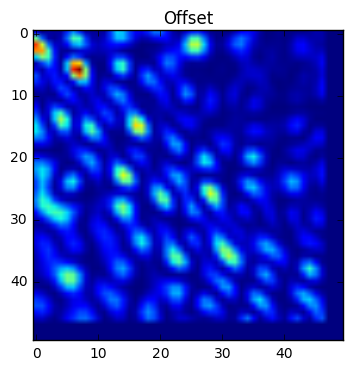

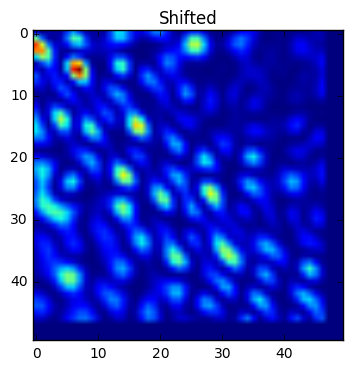

In [31]:
offset_config = toliman_settings.copy()
offset_config['tilt_x']=offset_as[0] # arcsecs
offset_config['tilt_y']=offset_as[1] # arcsecs
offset_source = source_a.copy()
offset_source['settings'] = offset_config
offset_psf_all = form_multi_psf('prescription_rc_quad', [offset_source], gridsize, common_sampling, npixels*2)
offset_detector_image = fix_prop_pixellate(offset_psf_all, common_sampling, detector_pitch, offset=(0,0))

centred_psf_all = form_multi_psf('prescription_rc_quad', [source_a], gridsize, common_sampling, npixels*2)
shifted_detector_image = fix_prop_pixellate(centred_psf_all, common_sampling, detector_pitch, offset=(offset_as[0]*m_per_as,offset_as[1]*m_per_as))


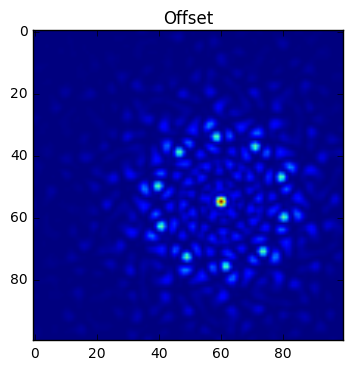

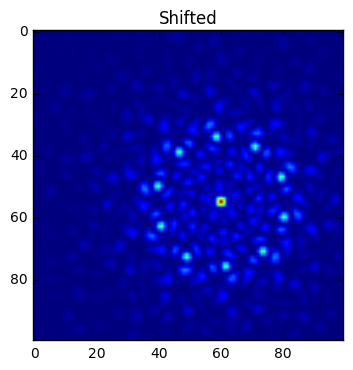

In [35]:
plt.imshow(offset_detector_image[256-50:256+50,256-50:256+50])
plt.title('Offset')
plt.show()
plt.imshow(shifted_detector_image[256-50:256+50,256-50:256+50])
plt.title('Shifted')
plt.show()